-----------------ALL THE PREVIOUS GIVEN INSTRUCTION AND CODE-------------

In [1]:
# Ensure pyarrow is installed in this kernel
!pip install --quiet pyarrow
!pip install pandas Pillow kagglehub ipywidgets numpy matplotlib pyarrow

In [2]:

import pandas as pd
from PIL import Image
import io
import numpy as np
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt


In [3]:
# Load parquet files
# Make sure to reference download instructions. You have to download the kaggle dataset and upload it, rename it to a data directory. Video guide coming soon
#from: https://drive.google.com/drive/folders/12-1XR8df-rYkwJuMqMgXYQ9dm6EoDx0f?usp=drive_link
#quickstart guide: https://www.youtube.com/watch?v=WPRarAeelAM
#Original source + description: https://advp.niagads.org/downloads
train_df = pd.read_parquet("/kaggle/input/mri-data/train.parquet")
test_df  = pd.read_parquet("/kaggle/input/mri-data/test.parquet")

def bytes_to_pixels(b: bytes) -> np.ndarray:
    """
    Convert raw image bytes (e.g. JPEG/PNG) into a 2D numpy array of pixel values (grayscale).
    """
    img = Image.open(io.BytesIO(b))  # convert to grayscale
    return np.array(img)
def extract_bytes(blob):
    """
    Unwrap a dict‐wrapped binary payload if needed,
    otherwise return blob directly.
    """
    if isinstance(blob, dict):
        # try common keys
        for key in ("bytes", "data", "image"):
            if key in blob and isinstance(blob[key], (bytes, bytearray)):
                return blob[key]
        # fallback: first bytes‐like value
        for v in blob.values():
            if isinstance(v, (bytes, bytearray)):
                return v
        raise TypeError(f"No bytes found in dict payload: {list(blob.keys())}")
    return blob

train_df["image"] = train_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))
test_df["image"]  = test_df["image"].apply(lambda blob: bytes_to_pixels(extract_bytes(blob)))




1. label = 2


/tmp/ipykernel_55/4051836937.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(pixels.astype("uint8"), mode="L")


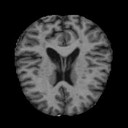

2. label = 0


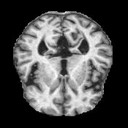

3. label = 3


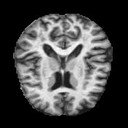

4. label = 3


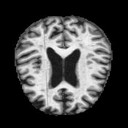

5. label = 2


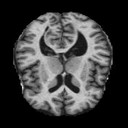

6. label = 2


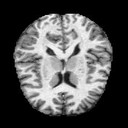

7. label = 2


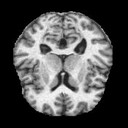

8. label = 2


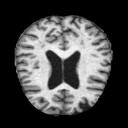

9. label = 3


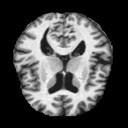

10. label = 2


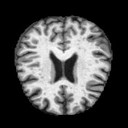

In [4]:
def display_images(df, n=10):
    """
    Display the first n grayscale images (numpy arrays) from df
    along with their labels. Assumes df has columns 'image' and 'label'.
    """
    for i, (_, row) in enumerate(df.head(n).iterrows(), start=1):
        pixels = row["image"]
        label = row.get("label", "")
        # Create a PIL image in 'L' mode (8-bit pixels, black and white)
        img = Image.fromarray(pixels.astype("uint8"), mode="L")
        print(f"{i}. label = {label}")
        display(img)
display_images(train_df)

-------------------------------------------------------------------

THIS IS WHERE MY CODE STARTS

--------TO CHECK THE BASIC STATS AND DIMENSION------------

Training Shape: (5120, 2)
Testing Shape: (1280, 2)


/tmp/ipykernel_55/3441695105.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='label', palette='viridis')


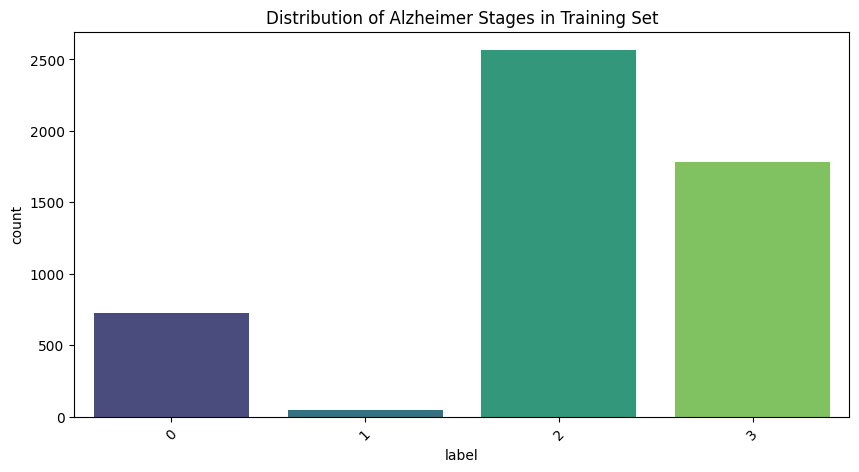

Average Resolution: 128.0x128.0
Min Resolution: 128x128
Max Resolution: 128x128


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io

# Basic Stats
print(f"Training Shape: {train_df.shape}")
print(f"Testing Shape: {test_df.shape}")

# Check for Class Imbalance
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='label', palette='viridis')
plt.title('Distribution of Alzheimer Stages in Training Set')
plt.xticks(rotation=45)
plt.show()

# Image Dimensionality Check
# MRI datasets often have inconsistent sizes; we need to verify this.
heights = train_df['image'].apply(lambda x: x.shape[0])
widths = train_df['image'].apply(lambda x: x.shape[1])

print(f"Average Resolution: {heights.mean():.1f}x{widths.mean():.1f}")
print(f"Min Resolution: {heights.min()}x{widths.min()}")
print(f"Max Resolution: {heights.max()}x{widths.max()}")

CHECK FOR GPU

In [6]:
import tensorflow as tf
#Check if GPU is available
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    print(f"GPU is active! Found {len(gpu_devices)} device(s).")
    #This allows memory to grow as needed rather than allocating all at once
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU not found. Please check Kaggle settings.")

2025-12-29 09:57:39.689412: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767002260.111951      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767002260.227461      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767002261.360715      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767002261.360752      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767002261.360755      55 computation_placer.cc:177] computation placer alr

GPU is active! Found 2 device(s).


-----------**HEADER**--------------------

In [7]:
import os
import io
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import cv2
import random


#Global Config
CFG = {
    "SEED": 42,
    "IMG_SIZE": (128, 128),
    "CHANNELS": 1,
    "BATCH_SIZE": 32,
    "EPOCHS": 100,
    "LR": 5e-4,
    "NUM_CLASSES": 4,
    "MODEL_PATH": "best_alzheimer_categorical_model.keras"
}

tf.random.set_seed(CFG["SEED"])
np.random.seed(CFG["SEED"])

---------**BODY**--------------

In [8]:
def extract_pixels(blob):
    """Parses binary MRI data from Parquet."""
    if isinstance(blob, dict):
        blob = blob.get('bytes', list(blob.values())[0])
    img = Image.open(io.BytesIO(blob)).convert('L')
    return np.array(img).astype('float32')
    
def load_and_split_data(train_path, test_path):
    """Loads parquet and creates categorical stratified splits."""
    train_df = pd.read_parquet(train_path)
    test_df  = pd.read_parquet(test_path)
    
    train_df["image"] = train_df["image"].apply(extract_pixels)
    test_df["image"]  = test_df["image"].apply(extract_pixels)
    
    #Stratified Split
    train_data, val_data = train_test_split(
        train_df, test_size=0.20, random_state=CFG["SEED"], stratify=train_df['label']
    )
    
    #Encode Labels to Integers first
    le = LabelEncoder()
    train_integers = le.fit_transform(train_data['label'])
    val_integers   = le.transform(val_data['label'])
    test_integers  = le.transform(test_df['label'])
    
    #Convert to Categorical (One-Hot)
    y_train = to_categorical(train_integers, num_classes=CFG["NUM_CLASSES"])
    y_val   = to_categorical(val_integers, num_classes=CFG["NUM_CLASSES"])
    y_test  = to_categorical(test_integers, num_classes=CFG["NUM_CLASSES"])
    
    return train_data, val_data, test_df, y_train, y_val, y_test, le.classes_, train_integers

def create_tf_dataset(df, labels, augment=False):
    """Converts numpy arrays to high-performance tf.data pipelines."""
    
    #Prepare data shape: Stack individual images into a single 4D numpy array
    X = np.stack(df['image'].values)
    
    #Add channel dimension: Convert (Batch, H, W) to (Batch, H, W, 1) for grayscale
    X = np.expand_dims(X, axis=-1) 
    
    #Initialize Dataset: Create a tf.data.Dataset from the numpy arrays
    ds = tf.data.Dataset.from_tensor_slices((X, labels))
    
    #Data Augmentation
    if augment:
        #Buffer-based shuffling to prevent the model from learning the order of data
        ds = ds.shuffle(1000)
        
        #Define a sequential model for geometric and color transformations
        aug_layer = keras.Sequential([
            layers.RandomFlip("horizontal"),  # Mirror images left-to-right
            layers.RandomRotation(0.05),      # Small random rotations
            layers.RandomZoom(0.05),          # Randomly zoom in/out
            layers.RandomContrast(0.2),       # Vary pixel intensity ranges
            layers.RandomBrightness(0.1)      # Randomly darken or lighten
        ])
        
        #Apply the augmentation transformations to each image in the dataset
        #'training=True' ensures layers like Dropout or RandomFlip remain active
        ds = ds.map(lambda x, y: (aug_layer(x, training=True), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    #Performance Optimization:
    # - .batch(): Group samples into fixed sizes
    # - .prefetch(): Prepare the next batch while the GPU is training on the current one
    return ds.batch(CFG["BATCH_SIZE"]).prefetch(tf.data.AUTOTUNE)

In [9]:

def residual_block(x, filters, kernel_size=(3, 3)):
    """Residual Block with Channel Attention (SE)."""
    #Save the input so we can add it back at the end (the "skip connection")
    shortcut = x 
    #Efficient convolution: Looks for shapes/patterns using less memory
    x = layers.SeparableConv2D(filters, kernel_size, padding='same')(x)
    #Standardization: Keeps the data 'well-behaved' so the model learns faster
    x = layers.BatchNormalization()(x)
    #Activation: A smooth 'filter' that helps the model learn complex math
    x = layers.Activation('swish')(x) 
    
    #Repeat the process to refine the features
    x = layers.SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    #--- Squeeze-and-Excitation ---
    #This part helps the model focus on the most important 'colors' or 'channels'
    se = layers.GlobalAveragePooling2D()(x)# Summarize each channel into one number
    se = layers.Dense(filters // 16, activation='relu')(se)# Compress information
    se = layers.Dense(filters, activation='sigmoid')(se)# Assign importance scores (0 to 1)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.Multiply()([x, se])# Multiply original features by their importance
    
    #--- The Shortcut Match ---
    #If the input shape doesn't match the output, resize it so we can add them
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)
    
    #Mix the 'original' info with the 'processed' info and return it
    x = layers.Add()([x, shortcut])
    x = layers.Activation('swish')(x)
    return x
    
def build_advanced_model(model_type="EfficientNetB0", fine_tune_at=None):
    # Define the starting point: what size is our image?
    inputs = layers.Input(shape=(*CFG["IMG_SIZE"], CFG["CHANNELS"]))
    
    #Transform the image into 3 channels (RGB) for the backbone
    x = layers.Conv2D(3, (3, 3), padding='same')(inputs)
    
    #A pre-trained model that already knows how to 'see'
    backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet', input_shape=(*CFG["IMG_SIZE"], 3)
    )
    
    #Decide if we want to freeze the backbone or let it learn a little
    if fine_tune_at is None:
        backbone.trainable = False# Lock the pre-trained knowledge
    else:
        backbone.trainable = True
        for layer in backbone.layers[:fine_tune_at]:
            layer.trainable = False# Lock only the early layers

    x = backbone(x)
    
    #Use our custom Residual Block for specific details
    x = residual_block(x, filters=256)
    
    #Global Summarizing: Take the best of both worlds (Average and Max features)
    avg_p = layers.GlobalAveragePooling2D()(x) # General 'vibe' of the image
    max_p = layers.GlobalMaxPooling2D()(x)    # Strongest 'signals' in the image
    x = layers.Concatenate()([avg_p, max_p])  # Put them together
    
    #The Decision Maker (Classification Head)
    # We use 'Dropout' to prevent the model from just memorizing the training data
    x = layers.Dense(1024, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x) 
    
    x = layers.Dense(512, activation='swish', kernel_regularizer=regularizers.l2(1e-3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x) 
    
    #Output the probability for each class
    outputs = layers.Dense(CFG["NUM_CLASSES"], activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    #Prepare the model for training
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=CFG["LR"]),
        #Label smoothing helps the model be less 'overconfident'
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    model.summary()
    
    return model

------- THIS WERE WERE ALL THE FUNCTIONS ARE CALLED----------

In [10]:

#Load & Split
train_data, val_data, test_df, y_train, y_val, y_test, class_names, train_ints = load_and_split_data(
    "/kaggle/input/mri-data/train.parquet", 
    "/kaggle/input/mri-data/test.parquet"
)

#Imbalance handling
weights = compute_class_weight('balanced', classes=np.unique(train_ints), y=train_ints)
class_weight_dict = dict(enumerate(weights))

#Create Datasets
train_ds = create_tf_dataset(train_data, y_train, augment=True)
val_ds   = create_tf_dataset(val_data, y_val)
test_ds  = create_tf_dataset(test_df, y_test)

#Initialize and Train
model = build_advanced_model(fine_tune_at=150)

#High-Detail Callbacks
callbacks = [
    #Stop early if the AUC score stops improving
    keras.callbacks.EarlyStopping(monitor='val_auc', patience=12, restore_best_weights=True, mode='max'),
    #Slow down learning if the loss stops dropping
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1),
    #Save the 'Best Version' of the model automatically
    keras.callbacks.ModelCheckpoint(filepath=CFG["MODEL_PATH"], monitor='val_auc', mode='max', save_best_only=True)
]

print("\n--- Starting Categorical Training ---")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=CFG["EPOCHS"],
    # class_weight=class_weight_dict,
    callbacks=callbacks
)



I0000 00:00:1767002280.984351      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767002280.988143      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │         30 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ conv2d[0][0]      │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 4, 4, 256) │    339,456 │ efficientnetb0[0… │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4, 256) │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 4, 4, 256) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 4, 4, 256) │     68,096 │ activation[0][0]  │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 256) │      1,024 │ separable_conv2d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │      4,352 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 256) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 4, 4, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 4, 4, 256) │    327,936 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 4, 256) │          0 │ multiply[0][0],   │
│                     │                   │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 4, 4, 256) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ activation_1[0][… │
│ (GlobalMaxPooling2… │                   │            │                 

 Total params: 5,853,909 (22.33 MB)

 Trainable params: 5,087,946 (19.41 MB)

 Non-trainable params: 765,963 (2.92 MB)


--- Starting Categorical Training ---
Epoch 1/100


I0000 00:00:1767002307.892204     137 service.cc:152] XLA service 0x794dc0001b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767002307.892240     137 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767002307.892244     137 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1767002312.042455     137 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-29 09:58:40.949560: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-29 09:58:41.083895: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-29 09:58:41.399541: E external/local_xl

128/128 ━━━━━━━━━━━━━━━━━━━━ 72s 120ms/step - accuracy: 0.3370 - auc: 0.5843 - loss: 2.6383 - val_accuracy: 0.5127 - val_auc: 0.7488 - val_loss: 2.7444 - learning_rate: 5.0000e-04
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.4584 - auc: 0.7147 - loss: 2.1409 - val_accuracy: 0.5352 - val_auc: 0.7953 - val_loss: 2.0326 - learning_rate: 5.0000e-04
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5035 - auc: 0.7711 - loss: 1.9613 - val_accuracy: 0.5674 - val_auc: 0.8043 - val_loss: 2.0091 - learning_rate: 5.0000e-04
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5328 - auc: 0.8103 - loss: 1.8129 - val_accuracy: 0.5986 - val_auc: 0.8530 - val_loss: 1.6865 - learning_rate: 5.0000e-04
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.5771 - auc: 0.8265 - loss: 1.7468 - val_accuracy: 0.6182 - val_auc: 0.8754 - val_loss: 1.5953 - learning_rate: 5.0000e-04
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accu

**---------MODEL TESTING----------**

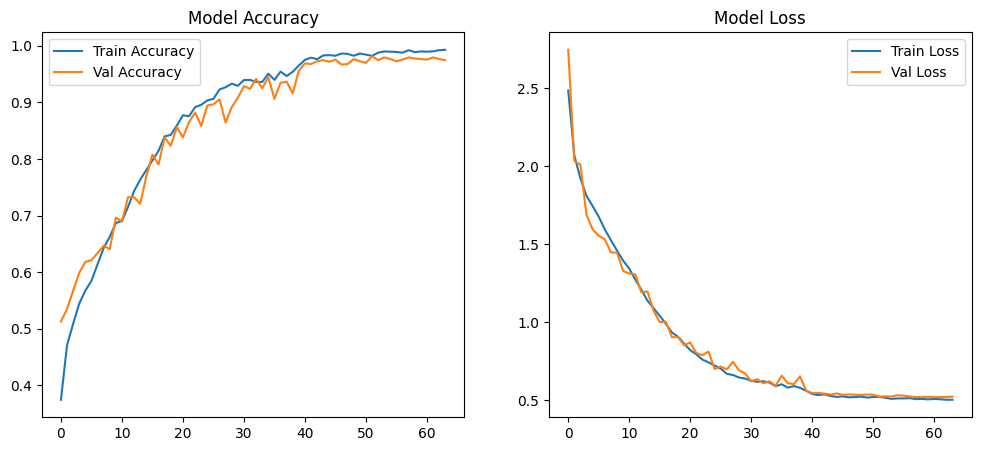

In [11]:
#Plot Training vs Validation Accuracy/Loss
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    #Accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].legend()
    
    #Loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Val Loss')
    ax[1].set_title('Model Loss')
    ax[1].legend()
    plt.show()

plot_history(history)


--- Evaluating on Unseen Test Data ---

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       172
           1       1.00      1.00      1.00        15
           2       0.98      0.99      0.98       634
           3       0.98      0.96      0.97       459

    accuracy                           0.98      1280
   macro avg       0.98      0.98      0.98      1280
weighted avg       0.98      0.98      0.98      1280

Final Test AUC-ROC Score: 0.9975


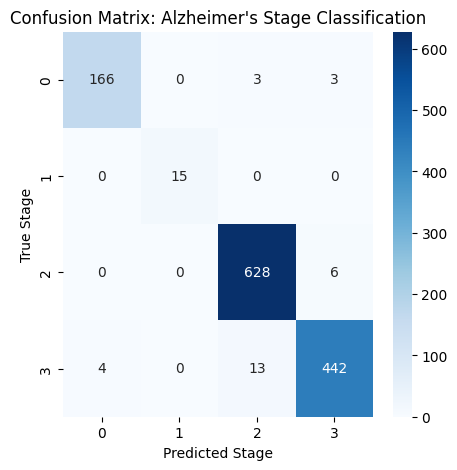

In [12]:
def evaluate_model_performance(model, test_ds, class_names):
    """
    Performs a comprehensive evaluation on the unseen test set.
    """
    print("\n--- Evaluating on Unseen Test Data ---")
    
    #Ensure class_names are strings for the report formatting
    target_names = [str(name) for name in class_names]
    
    #Get True Labels and Predictions
    y_true = []
    y_pred_probs = []
    
    #Predict in batches to save memory
    for images, labels in test_ds:
        #labels are one-hot, so use argmax to get the true class index
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        preds = model.predict(images, verbose=0)
        y_pred_probs.extend(preds)
        
    y_pred_probs = np.array(y_pred_probs)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    
    #Detailed Classification Report
    #Fixed: Passing target_names as a list of strings
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=target_names))
    
    #AUC-ROC Calculation
    #multi_class='ovr' (One-vs-Rest) is best for categorical medical evaluation
    overall_auc = roc_auc_score(
        tf.keras.utils.to_categorical(y_true), 
        y_pred_probs, 
        multi_class='ovr'
    )
    print(f"Final Test AUC-ROC Score: {overall_auc:.4f}")

    #Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, 
                yticklabels=target_names)
    plt.title("Confusion Matrix: Alzheimer's Stage Classification")
    plt.ylabel('True Stage')
    plt.xlabel('Predicted Stage')
    plt.show()

#Execute Evaluation
#Ensure 'class_names' here is the variable returned by your train_pipeline()
evaluate_model_performance(model, test_ds, class_names)

**-------Grad-CAM------**

In [13]:
def get_last_conv_layer(model):
    """
    Finds the last convolutional layer inside EfficientNet backbone.
    """
    #Grab the 'EfficientNet' part of your model
    backbone = model.get_layer("efficientnetb0")
    
    #Look through the layers backwards (starting from the end)
    for layer in reversed(backbone.layers):
        #If we find a 2D Convolutional layer, stop and return its name
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
            
    #If no layer is found, show an error message
    raise ValueError("No Conv2D layer found in backbone.")

In [14]:
# TARGET_LAYER_NAME = get_last_conv_layer(model)
# print("Using Grad-CAM layer:", TARGET_LAYER_NAME)
TARGET_LAYER = "separable_conv2d_1"


In [15]:
def compute_gradcam(model, image, class_index, layer_name):
    """Calculates the importance of pixels for a specific prediction."""
    
    #Target the specific layer we want to look at
    target_layer = model.get_layer(layer_name)

    #Create a temporary model that outputs both the features and the final prediction
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[target_layer.output, model.output]
    )

    #Use 'GradientTape' to watch how the prediction changes 
    #as we nudge the pixels in the target layer
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index] # Focus only on the predicted class

    #Calculate the gradients (the 'influence' of each feature)
    grads = tape.gradient(loss, conv_outputs)

    #Average the influence across the image channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    #Build the heatmap by multiplying features by their importance
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    #Clean up: Remove negative values and scale from 0 to 1
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

In [16]:
def show_gradcam(model, image, class_names, layer_name):
    #Predict the class
    preds = model.predict(image, verbose=0)
    class_index = np.argmax(preds)
    confidence = preds[0][class_index]

    #Generate the raw heatmap
    heatmap = compute_gradcam(model, image, class_index, layer_name)

    # Convert the normalized image back to standard 0-255 pixels
    img = image[0].numpy()
    img = (img - img.min()) / (img.max() - img.min())
    img = (img * 255).astype(np.uint8)

    #If grayscale, convert to 3-channel RGB so we can add color
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)

    #Resize heatmap to match the MRI size and apply the 'JET' color map (Blue to Red)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    #Blend the original image (60%) with the heatmap (40%)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    # Plot the results side-by-side
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); 
    plt.title("Original MRI"); 
    plt.imshow(img)
    
    plt.subplot(1, 3, 2); 
    plt.title("Heatmap Only"); 
    plt.imshow(heatmap, cmap="jet")
    
    plt.subplot(1, 3, 3); 
    plt.title(f"Overlay: {class_names[class_index]} ({confidence:.2f})")
    plt.imshow(overlay); 
    plt.show()

In [17]:
def show_random_gradcams_with_truth(model, dataset, class_names, layer_name, num_images=5):
    samples = []

    #Grab a pool of images from the dataset
    for images, labels in dataset:
        for i in range(images.shape[0]):
            samples.append((images[i:i+1], labels[i]))
        if len(samples) >= 100: break

    #Pick random samples to visualize
    selected = random.sample(samples, num_images)

    for idx, (image, true_label) in enumerate(selected):
            preds = model.predict(image, verbose=0)
            pred_class = np.argmax(preds)
            confidence = preds[0][pred_class]
    
            true_class = np.argmax(true_label.numpy())
    
            print(f"\nSample {idx+1}")
            print(f"True Label      : {class_names[true_class]}")
            print(f"Predicted Label : {class_names[pred_class]} ({confidence:.2f})")
    
            show_gradcam(
                model=model,
                image=image,
                class_names=class_names,
                layer_name=layer_name
            )

2025-12-29 10:07:27.351466: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-29 10:07:27.487284: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-29 10:07:28.146696: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-29 10:07:28.282597: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-29 10:07:28.929174: E external/local_xla/xla/stream_


Sample 1
True Label      : 2
Predicted Label : 2 (0.88)


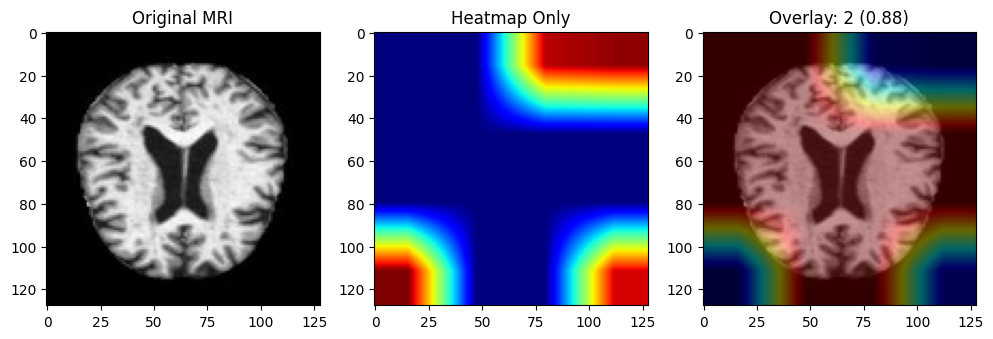


Sample 2
True Label      : 0
Predicted Label : 0 (0.82)


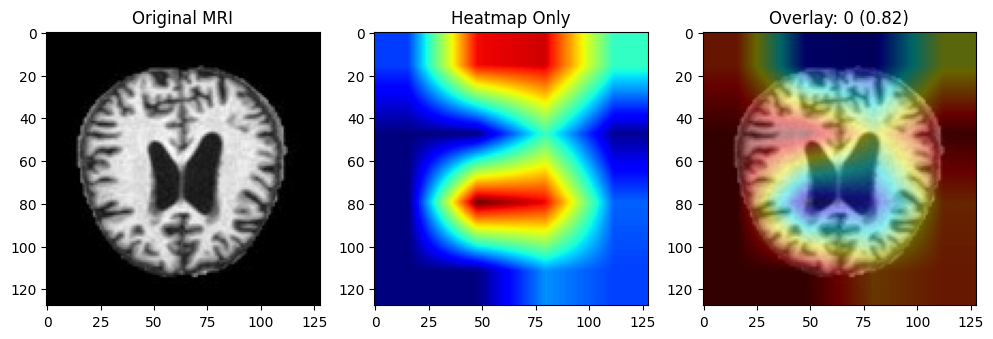


Sample 3
True Label      : 2
Predicted Label : 2 (0.88)


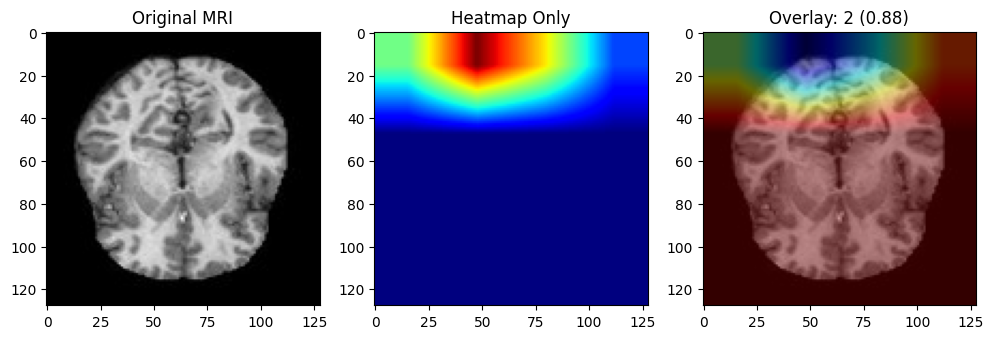


Sample 4
True Label      : 3
Predicted Label : 3 (0.89)


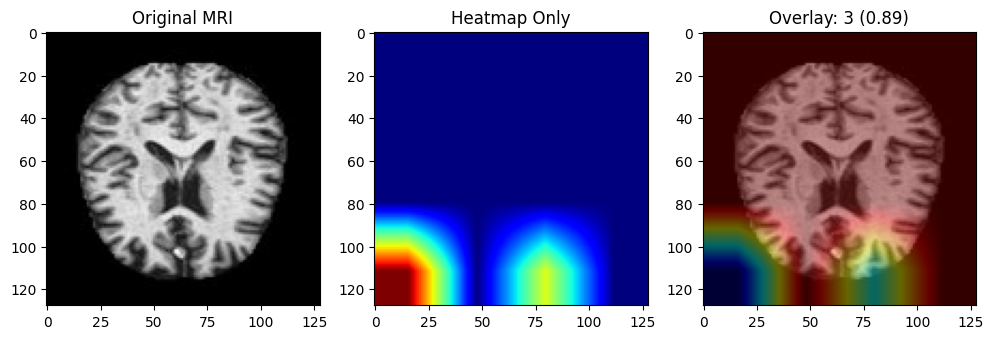


Sample 5
True Label      : 2
Predicted Label : 2 (0.91)


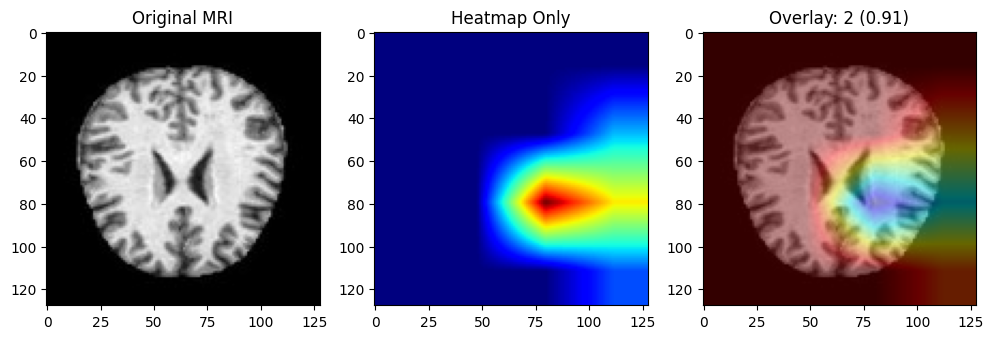

In [18]:
show_random_gradcams_with_truth(
    model=model,
    dataset=test_ds,
    class_names=class_names,
    layer_name=TARGET_LAYER,
    num_images=5
)
